Nhập thư viện

In [ ]:
# Cài đặt thư viện NeuralForecast
!pip install neuralforecast

In [ ]:
# Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nhập các thành phần chính từ neuralforecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.models.nhits import NHITS

In [ ]:
# Lấy dữ liệu từ Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-fashion-retail-stores-dataset' dataset.
Path to dataset files: /kaggle/input/global-fashion-retail-stores-dataset


In [ ]:
data = pd.read_csv(path+'/transactions.csv')

Tiền xử lý dữ liệu

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date Normalize'] = data['Date'].dt.normalize()

In [ ]:
exchange_rates = pd.DataFrame({
    "Currency": ["USD", "CNY", "GBP", "EUR"],
    "to_USD": [1.00, 0.14, 1.33, 1.16]
})
data_temp = data.merge(exchange_rates, on='Currency', how='left')
data_temp['to_USD'] = data_temp['to_USD'].fillna(1.0)
data['Line Total'] = data_temp['Line Total'] * data_temp['to_USD']
del data_temp

In [ ]:
grouped_data = data.groupby('Date Normalize')['Line Total'].sum()
group_data_df = grouped_data.to_frame()

In [ ]:
group_data_df

,Line Total
Date Normalize,
2023-01-01,759856.5580
2023-01-02,177565.8705
2023-01-03,158566.6598
2023-01-04,164006.1005
2023-01-05,157792.9851
...,...
2025-03-14,312090.5200
2025-03-15,747498.5142
2025-03-16,770373.4691


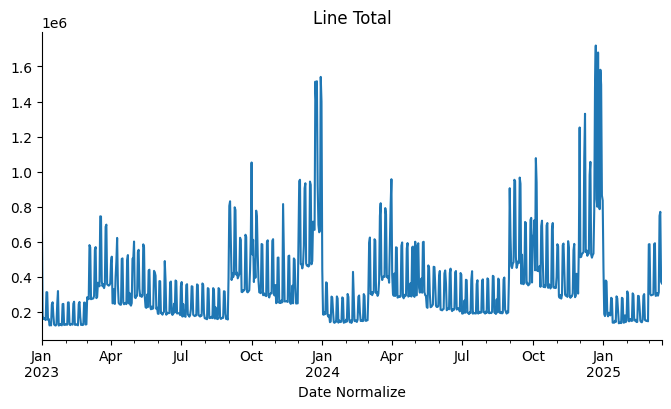

In [ ]:
# Dữ liệu dùng để train
from matplotlib import pyplot as plt
group_data_df['Line Total'].plot(kind='line', figsize=(8, 4), title='Line Total')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Chuẩn hóa dữ liệu theo đầu vào của mô hình
df_clean = group_data_df
df_clean = df_clean.reset_index()
df_clean = df_clean.rename(columns={'Date Normalize': 'ds'})
df_clean = df_clean.rename(columns={'Line Total': 'y'})
df_clean['unique_id'] = 'Total Sales'
df_final = df_clean[['unique_id', 'ds', 'y']]

In [ ]:
#TÍNH TOÁN KÍCH THƯỚC
total_length = len(df_final)
test_size = int(total_length * 0.10)
val_size = int(total_length * 0.20) # 20% cho validation

Huấn luyện mô hình

In [ ]:
HORIZON = test_size
INPUT_SIZE = test_size * 2

nhits_model = NHITS(
    h=HORIZON, # Số bước thời gian (time steps) trong tương lai mà mô hình cần dự đoán
    input_size=INPUT_SIZE, # Số bước thời gian trong quá khứ được sử dụng làm đầu vào để dự đoán h bước tương lai
    max_steps=1000, # Tổng số lần cập nhật trọng số (batch/step) tối đa mà mô hình sẽ thực hiện trong quá trình huấn luyện.
    scaler_type='robust', # Phương pháp được sử dụng để chuẩn hóa dữ liệu đầu vào. robustScaler thường tốt hơn khi dữ liệu có ngoại lai (outliers), vì nó dùng trung vị (median) thay vì trung bình.
    learning_rate=0.001, # Tham số quan trọng trong quá trình tối ưu hóa, kiểm soát mức độ điều chỉnh trọng số của mạng sau mỗi lần lan truyền ngược.
    early_stop_patience_steps=5, # Số bước huấn luyện (training steps) tối đa mà mô hình sẽ tiếp tục chạy sau khi hiệu suất trên tập hợp hợp lệ (validation loss) ngừng cải thiện. Nếu hiệu suất không cải thiện sau 5 bước liên tiếp, quá trình huấn luyện sẽ dừng lại để tránh quá khớp (overfitting).
    val_check_steps=50, # Số bước huấn luyện (training steps) trước khi mô hình chạy kiểm tra trên tập dữ liệu hợp lệ (validation set).
)
models_list = [nhits_model]

nf = NeuralForecast(
    models=models_list,
    freq='D'
)

# Redefine data splits for explicit evaluation in evaluate_overfitting
total_length = len(df_final)
test_size = int(total_length * 0.10)
val_size = int(total_length * 0.20)

# Explicitly define train, val, test sets for the evaluation function
train_df = df_final.iloc[:-(val_size + test_size)] # This is the main training data
val_df = df_final.iloc[len(train_df):len(train_df) + val_size] # This is the validation set
test_df = df_final.iloc[len(train_df) + len(val_df):] # This is the test set

# Fit the model on the explicit training data, including validation set for early stopping.
nf.fit(df=pd.concat([train_df, val_df]), val_size=len(val_df))

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.389    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import display

def evaluate_overfitting(y_val_true, y_val_pred, y_test_true, y_test_pred):

    # Hàm tính metric an toàn (fix MAPE zero-division)
    def get_metrics(y_true, y_pred):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2   = r2_score(y_true, y_pred)

        # MAPE safe
        eps = 1e-9
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

        return [mae, rmse, r2, mape]

    # Tính metrics
    metrics_val   = get_metrics(y_val_true, y_val_pred)
    metrics_test  = get_metrics(y_test_true,  y_test_pred)

    # DataFrame
    df_compare = pd.DataFrame(
        [metrics_val, metrics_test],
        columns=['MAE', 'RMSE', 'R2 Score', 'MAPE'],
        index=['Validate', 'Test']
    )

    print("=== BẢNG SO SÁCH HIỆU SUẤT MÔ HÌNH ===")
    display(df_compare)


In [ ]:
# ================================
# 1. PREDICT TEST SET
# ================================
pred_test = nf.predict(df=pd.concat([train_df,val_df]), h=len(test_df))  # hoặc dùng riêng train_df nếu bạn tách


y_test_true = test_df['y'].values
y_test_pred = pred_test['NHITS'].values


# ================================
# 2. PREDICT VALIDATION SET
#    (dự báo bằng cách kéo dài horizon)
# ================================
pred_val = nf.predict(df=train_df, h=len(val_df))

# Chỉ lấy phần đầu tiên tương ứng validation
y_val_pred = pred_val['NHITS'].values
y_val_true = val_df['y'].values

# ================================
# 4. EVALUATE
# ================================
evaluate_overfitting(y_val_true, y_val_pred,y_test_true, y_test_pred)


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

=== BẢNG SO SÁCH HIỆU SUẤT MÔ HÌNH ===


,MAE,RMSE,R2 Score,MAPE
Validate,82455.610917,157541.899400,0.715835,0.160793
Test,69702.951674,99925.150848,0.784082,0.311465


In [ ]:
# This cell will now generate predictions specifically for the test set.
# `nf` was fitted on `train_df`. To predict for `test_df`, we need to feed `train_df` and `val_df` as history.
# We predict `test_size` steps beyond the combined `train_df` and `val_df`.
predictions_df = nf.predict(df=pd.concat([train_df, val_df]), h=test_size)

# In ra kết quả dự đoán
print(predictions_df)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

      unique_id         ds         NHITS
0   Total Sales 2024-12-29  1.641460e+06
1   Total Sales 2024-12-30  8.771436e+05
2   Total Sales 2024-12-31  5.055375e+05
3   Total Sales 2025-01-01  3.820966e+05
4   Total Sales 2025-01-02  3.668263e+05
..          ...        ...           ...
75  Total Sales 2025-03-14  2.822782e+05
76  Total Sales 2025-03-15  7.411351e+05
77  Total Sales 2025-03-16  8.171436e+05
78  Total Sales 2025-03-17  3.756623e+05
79  Total Sales 2025-03-18  3.512264e+05

[80 rows x 3 columns]


Kết quả của mô hình

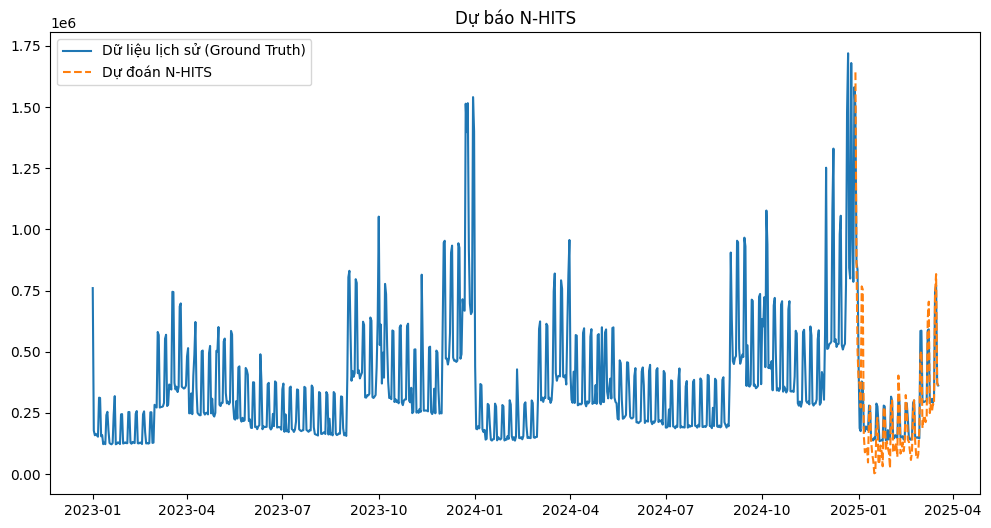

In [ ]:
# For plotting, we need all historical data and the test predictions.
plot_df = pd.concat([train_df, val_df, test_df]).set_index('ds')

plt.figure(figsize=(12, 6))
# Vẽ dữ liệu lịch sử (y) - all historical data
plt.plot(plot_df['y'], label='Dữ liệu lịch sử (Ground Truth)')
# Vẽ dự đoán (N-HITS) - just for the test period. predictions_df contains test predictions.
plt.plot(predictions_df.set_index('ds')['NHITS'], label='Dự đoán N-HITS', linestyle='--')

plt.title('Dự báo N-HITS')
plt.legend()
plt.show()

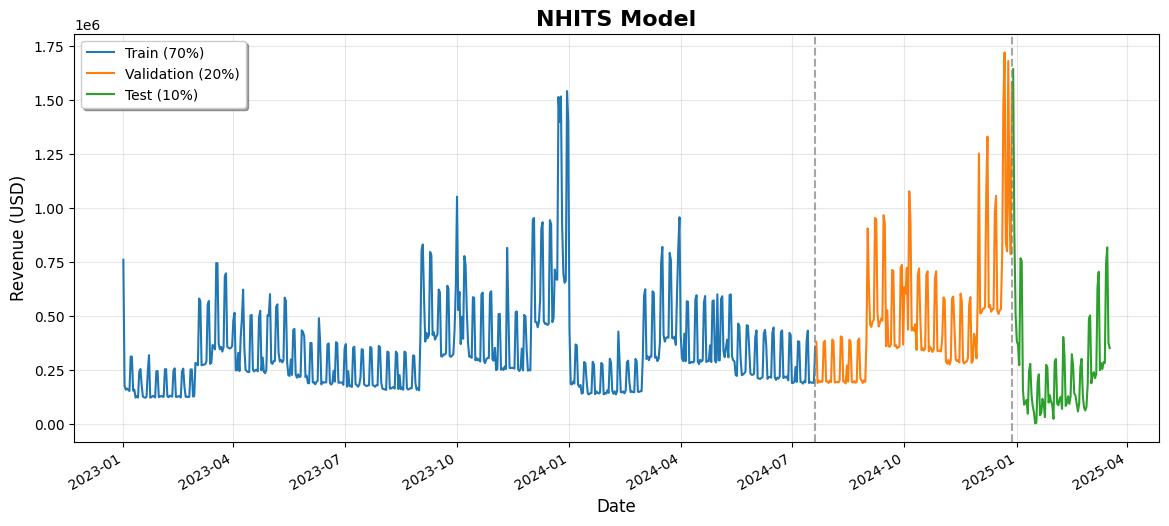

In [ ]:
import matplotlib.dates as mdates
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(14, 6))

# Vẽ đường Train (Màu xanh dương)
plt.plot(train_df['ds'], train_df['y'], label='Train (70%)', color='#1f77b4', linewidth=1.5)

# Vẽ đường Validate (Màu cam)
plt.plot(val_df['ds'], val_df['y'], label='Validation (20%)', color='#ff7f0e', linewidth=1.5)

# Vẽ đường Test/Predict (Màu xanh lá)
plt.plot(test_df['ds'], predictions_df.set_index('ds')['NHITS'], label='Test (10%)', color='#2ca02c', linewidth=1.5)

# --- Vẽ đường gạch đứt phân chia các phần ---
# Lấy ngày cuối cùng của tập Train để vẽ vạch ngăn cách 1
split_date_1 = train_df['ds'].iloc[-1]
plt.axvline(x=split_date_1, color='gray', linestyle='--', alpha=0.7)

# Lấy ngày cuối cùng của tập Val để vẽ vạch ngăn cách 2
split_date_2 = val_df['ds'].iloc[-1]
plt.axvline(x=split_date_2, color='gray', linestyle='--', alpha=0.7)

# --- Trang trí biểu đồ ---
plt.title('NHITS Model', fontsize=16, fontweight='bold')
plt.ylabel('Revenue (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True) # Hộp chú thích
plt.grid(True, alpha=0.3) # Lưới mờ nền sau

# Format trục ngày tháng cho dễ nhìn (nghiêng 45 độ)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

# Hiển thị
plt.show()